## Import CSV

In [42]:
import pandas
def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')


In [43]:
folder="/nfs/Workspace/"
data=read_csv(filename="FINAL_TRAIN",folder=folder)
data.columns = ( 'DATE','vfx' ,'vbx', 'vmt','rwm','dog','psh','spx')
data = data.fillna(method='ffill')
data.head()

,DATE,vfx,vbx,vmt,rwm,dog,psh,spx
0,2017/5/5,208.064148,9.794650,24.294504,45.874645,69.404022,32.990784,4615.089844
1,2017/5/12,207.510513,9.812943,24.159153,46.313114,69.716293,33.087994,4602.959961
2,2017/5/19,206.844238,9.858670,24.178493,46.839294,69.950508,33.185196,4588.350098
3,2017/5/26,209.875275,9.849524,24.255835,46.303379,69.052704,32.718620,4655.649902
4,2017/6/2,211.977325,9.915467,24.719877,45.494625,68.545250,32.388126,4702.560059


In [44]:
from matplotlib import pyplot
def plot_data(dataset,groups):
    i = 1
    pyplot.figure()
    values = dataset.values
    for group in groups:
    	pyplot.subplot(len(groups), 1, i)
    	pyplot.plot(values[:, group])
    	pyplot.title(dataset.columns[group], y=0.5, loc='right')
    	i += 1
    pyplot.show()

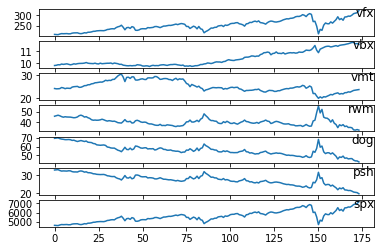

In [45]:
plot_data(data,groups=list(range(1,8)))

## Data Summary

In [46]:
data.describe()

,vfx,vbx,vmt,rwm,dog,psh,spx
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,252.023549,10.351102,25.249413,40.581595,56.158490,27.554384,5604.535628
std,26.528003,0.605221,2.388251,3.513995,5.956887,3.019515,596.803618
min,206.844238,9.711603,20.059999,32.709999,42.669998,19.610001,4588.350098
25%,233.126881,9.858670,23.598254,38.131068,52.490212,25.895415,5186.832398
50%,248.611587,9.997527,24.723773,40.383860,55.455484,27.737020,5528.060059
75%,268.835609,10.844124,27.637063,42.220478,58.673307,29.445991,5984.462403
max,323.280121,11.721215,30.474449,55.535786,69.950508,33.185196,7207.100098


## Independent and identically distributed (I.I.D.) Testing

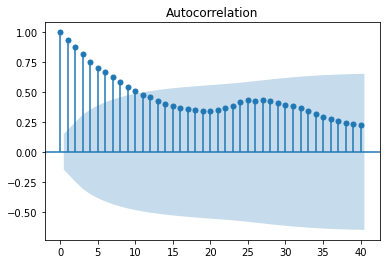

In [47]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(data['vfx'].values, lags=40)
plt.show()

## *** LSTM ***

In [48]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
def Standard_MinMax(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    
    return sc.fit_transform(data.reshape(-1,1))

In [49]:
#folder="/Users/wenyongjing/Downloads/第二章"
#data=read_csv(filename="WEN",folder=folder)
#data.columns = ( 'DATE','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh', 'spx')
del data['DATE']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
data.head()

,vfx,vbx,vmt,rwm,dog,psh,spx
0,208.064148,9.794650,24.294504,45.874645,69.404022,32.990784,4615.089844
1,207.510513,9.812943,24.159153,46.313114,69.716293,33.087994,4602.959961
2,206.844238,9.858670,24.178493,46.839294,69.950508,33.185196,4588.350098
3,209.875275,9.849524,24.255835,46.303379,69.052704,32.718620,4655.649902
4,211.977325,9.915467,24.719877,45.494625,68.545250,32.388126,4702.560059


## Series to Supervised

In [50]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [51]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.010477,0.041325,0.406599,0.576744,0.979968,0.985679,0.010211,0.005722,0.050428,0.393603,0.595954,0.991415,0.992840,0.005579
2,0.005722,0.050428,0.393603,0.595954,0.991415,0.992840,0.005579,0.000000,0.073182,0.395460,0.619006,1.000000,1.000000,0.000000
3,0.000000,0.073182,0.395460,0.619006,1.000000,1.000000,0.000000,0.026032,0.068631,0.402886,0.595527,0.967090,0.965630,0.025699
4,0.026032,0.068631,0.402886,0.595527,0.967090,0.965630,0.025699,0.044085,0.101445,0.447443,0.560096,0.948489,0.941285,0.043612
5,0.044085,0.101445,0.447443,0.560096,0.948489,0.941285,0.043612,0.039088,0.087766,0.431662,0.536617,0.939903,0.948446,0.038736


In [52]:
pred = {'vfx': 7}
reframed = pandas.concat([reframed.iloc[:,0:7],reframed.iloc[:,pred['vfx']]],axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.010477,0.041325,0.406599,0.576744,0.979968,0.985679,0.010211,0.005722
2,0.005722,0.050428,0.393603,0.595954,0.991415,0.992840,0.005579,0.000000
3,0.000000,0.073182,0.395460,0.619006,1.000000,1.000000,0.000000,0.026032
4,0.026032,0.068631,0.402886,0.595527,0.967090,0.965630,0.025699,0.044085
5,0.044085,0.101445,0.447443,0.560096,0.948489,0.941285,0.043612,0.039088


In [53]:
reframed.shape

(173, 8)

## Data Split

In [54]:
train = reframed.values[:100,:]
test = reframed.values[100:174,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((100, 7), (100,), (73, 7), (73,))

## LSTM

In [55]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

import keras
from keras import layers
from keras.layers import Dropout

model = keras.models.Sequential()
model.add(layers.LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


## Training

In [56]:
history = model.fit(train_X, train_y, epochs=80, 
                    batch_size=9, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/80
12/12 [==============================] - 0s 31ms/step - loss: 0.1453 - val_loss: 0.4568
Epoch 2/80
12/12 [==============================] - 0s 3ms/step - loss: 0.1120 - val_loss: 0.3975
Epoch 3/80
12/12 [==============================] - 0s 7ms/step - loss: 0.0862 - val_loss: 0.3465
Epoch 4/80
12/12 [==============================] - 0s 8ms/step - loss: 0.0659 - val_loss: 0.3020
Epoch 5/80
12/12 [==============================] - 0s 8ms/step - loss: 0.0500 - val_loss: 0.2626
Epoch 6/80
12/12 [==============================] - 0s 7ms/step - loss: 0.0374 - val_loss: 0.2275
Epoch 7/80
12/12 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.1967
Epoch 8/80
12/12 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.1702
Epoch 9/80
12/12 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.1481
Epoch 10/80
12/12 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.1301
Epoch 11/80
12/12 

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['real', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


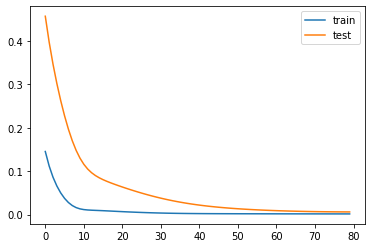

In [57]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [75]:
import datetime
folder="/nfs/Workspace/"
pred_data=read_csv(filename="FINAL_PRED",folder=folder)
pred_data.columns = ( 'Date','vfx','vbx', 'vmt','rwm','dog','psh', 'spx')
#pred_data.isnull().sum()
pred_data = pred_data.fillna(method='ffill')
# Copy Last date to tomorrow
tmp = pred_data[-1:].values.tolist()
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
tomorrow = tomorrow.strftime("%y%y/%m/%d")
tmp[0][0] = tomorrow
pred_data.loc[len(pred_data)] = tmp[0]
pred_data_bkp = np.array(pred_data['vfx']);
print(pred_data)
print(pred_data_bkp)

          Date         vfx        vbx        vmt        rwm        dog  \
0    2020/5/15  262.640198  11.370819  21.541000  42.529999  52.959999   
1    2020/5/22  271.224365  11.410404  22.011000  39.230000  51.099998   
2    2020/5/29  279.471558  11.452066  22.191000  38.020000  49.169998   
3     2020/6/5  293.309326  11.392575  22.420000  35.040001  45.970001   
4    2020/6/12  279.431885  11.471897  21.871000  37.779999  48.330002   
5    2020/6/19  284.685486  11.501643  22.117001  36.869999  47.799999   
6    2020/6/26  276.529541  11.521473  21.972000  37.919998  49.299999   
7     2020/7/6  292.335510  11.542351  22.490000  36.099998  46.860001   
8    2020/7/10  292.903198  11.582084  22.513000  36.590000  47.230000   
9    2020/7/17  296.618164  11.611882  22.853001  35.209999  46.110001   
10   2020/7/24  295.811432  11.661548  22.733000  35.320000  46.430000   
11   2020/7/31  301.000397  11.711266  23.090000  34.980000  46.470001   
12    2020/8/7  308.480102  11.721215 

In [76]:
del pred_data['Date']
scaler = MinMaxScaler(feature_range=(0, 1))
pred_scaled = scaler.fit_transform(pred_data)
pred_data.head()

,vfx,vbx,vmt,rwm,dog,psh,spx
0,262.640198,11.370819,21.541,42.529999,52.959999,24.480000,5852.839844
1,271.224365,11.410404,22.011,39.230000,51.099998,23.670000,6044.160156
2,279.471558,11.452066,22.191,38.020000,49.169998,22.980000,6227.810059
3,293.309326,11.392575,22.420,35.040001,45.970001,21.870001,6536.580078
4,279.431885,11.471897,21.871,37.779999,48.330002,22.850000,6227.419922


In [77]:
pred_reframed = series_to_supervised(pred_scaled, 1, 1)
pred_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.107679,0.112972,0.134709,0.796045,0.859304,0.869775,0.107367
2,0.107679,0.112972,0.134709,0.796045,0.859304,0.869775,0.107367,0.211132,0.231873,0.186300,0.721261,0.713313,0.758842,0.210429
3,0.211132,0.231873,0.186300,0.721261,0.713313,0.758842,0.210429,0.384712,0.062090,0.251935,0.537083,0.471256,0.580386,0.383708
4,0.384712,0.062090,0.251935,0.537083,0.471256,0.580386,0.383708,0.210634,0.288468,0.094583,0.706428,0.649773,0.737942,0.210210
5,0.210634,0.288468,0.094583,0.706428,0.649773,0.737942,0.210210,0.276535,0.373361,0.165090,0.650185,0.609682,0.668810,0.276027


In [78]:
pred = {'vfx': 7}
pred_reframed = pandas.concat([pred_reframed.iloc[:,0:7],pred_reframed.iloc[:,pred['vfx']]],axis=1)
pred_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.107679
2,0.107679,0.112972,0.134709,0.796045,0.859304,0.869775,0.107367,0.211132
3,0.211132,0.231873,0.186300,0.721261,0.713313,0.758842,0.210429,0.384712
4,0.384712,0.062090,0.251935,0.537083,0.471256,0.580386,0.383708,0.210634
5,0.210634,0.288468,0.094583,0.706428,0.649773,0.737942,0.210210,0.276535


In [79]:
pred_test = pred_reframed.values[:,:]
pred_test_X , pred_test_y  = pred_test[:, :-1], pred_test[:, -1]
pred_test_X.shape, pred_test_y.shape

((31, 7), (31,))

In [80]:
pred_test_X  = pred_test_X.reshape((pred_test_X.shape[0], 1, pred_test_X.shape[1]))
pred_test_X.shape, pred_test_y.shape

pred_yhat = model.predict(pred_test_X)

pred_test_X = pred_test_X.reshape((pred_test_X.shape[0], pred_test_X.shape[2]))
pred_yhat.shape, pred_test_X.shape

((31, 1), (31, 7))

## Invert scaling for forecast

In [81]:
pred = {'vfx': 0}
pred_inv_yhat = concatenate((pred_yhat, numpy.delete(pred_test_X, pred['vfx'], axis=1)), axis=1)
pred_inv_yhat = scaler.inverse_transform(pred_inv_yhat)
pred_inv_yhat = pred_inv_yhat[:,0]
pred_inv_yhat.shape,pred_inv_yhat

((31,),
 array([259.9938736 , 267.92552803, 275.69025928, 289.16517228,
        276.07645835, 281.78519739, 274.42961519, 290.35092293,
        291.08777384, 296.6534211 , 296.34705482, 302.72060233,
        311.87513101, 311.64191907, 314.12952265, 320.88887247,
        315.8311288 , 308.78199841, 308.03236076, 304.97852921,
        310.67838025, 320.44664883, 321.59584964, 318.78666256,
        302.59213144, 323.80480581, 328.21841314, 328.44069625,
        333.3632169 , 335.02971297, 334.56158798]))

## Invert scaling for actual

In [82]:
real = pred_test_y.reshape((len(pred_test_y), 1))
inv_y = concatenate((real, numpy.delete(pred_test_X, pred['vfx'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y
print(inv_y[-3:])
print(pred_inv_yhat[-3:])

[342.3599854 339.1099854 339.1099854]
[333.3632169  335.02971297 334.56158798]


## RMSE

In [83]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, pred_inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.962


In [84]:
from RegscorePy import *
aic.aic(inv_y, pred_inv_yhat, 367)

869.9645774071935

In [85]:
#inv_y = np.cumprod(inv_y+1)
#inv_yhat = np.cumprod(inv_yhat+1)
len(inv_y),len(pred_inv_yhat)

(31, 31)

## Predict vs Real

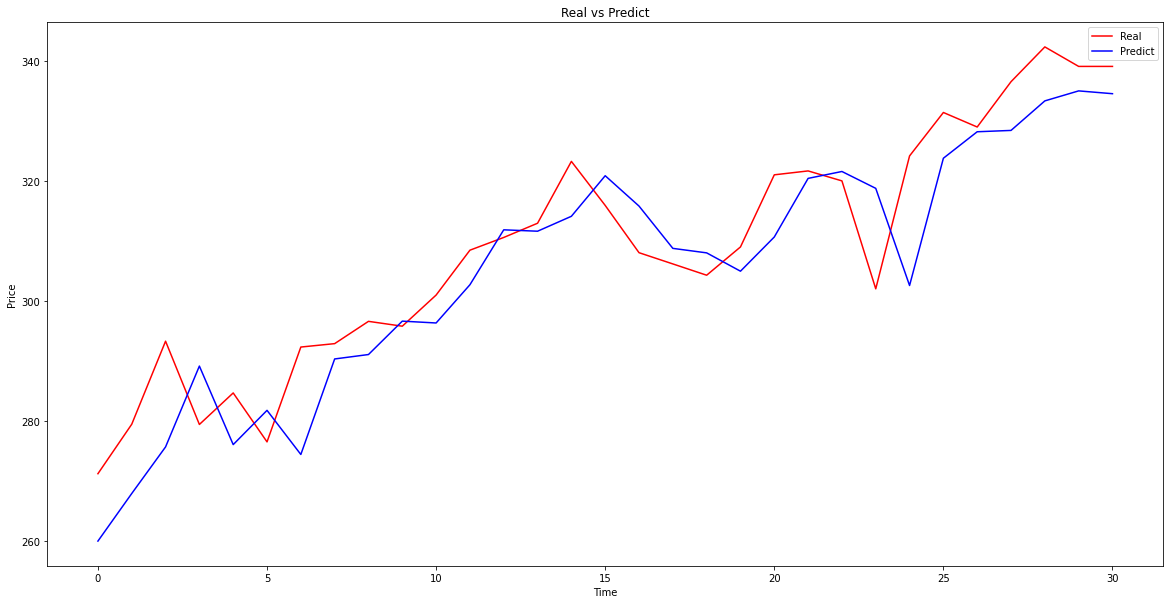

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(pred_inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 將樣本數轉成報酬率

In [87]:
import array
#print(pred_data_bkp)
#samples = np.array(pred_data_bkp)
samples = np.array(data['vfx'])

arr1 = []
for i in range(len(samples)-1):
  arr1.append((samples[i+1]-samples[i])/samples[i])

#轉換成報酬率
arr2 = np.array(arr1)
#標準差
std = np.std(arr2, ddof=1)
mean = np.mean(arr2)
#print(arr1)
print(std, mean)

0.027703980868269744 0.002940828857662545


## 算出最後一筆報酬率與標準差比較

In [88]:
print(pred_data_bkp[-3:])
print(pred_inv_yhat[-3:])
pred_last1 = (pred_data_bkp[-2] - pred_data_bkp[-3]) / pred_data_bkp[-3]
#pred_last2 = pred_inv_yhat[len(pred_inv_yhat)-1]
#newReturn = (pred_last1/pred_last2)/pred_last1
up_bond = mean + std
down_bond = mean - std
if pred_last1 >= up_bond:
    res = 1
elif pred_last1 <= down_bond:
    res = -1
else:
    res = 0
print(pred_last1)
print(res)

[342.3599854 339.1099854 339.1099854]
[333.3632169  335.02971297 334.56158798]
-0.009492931822049319
0


In [271]:
result_pred = pandas.DataFrame(pred_inv_yhat,columns =['Pred_VFNIX'])
temp =read_csv(filename="PRED_NEW",folder=folder)
temp.columns = ( 'Date','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh', 'spx')                                                    
temp = temp[['Date','vfx']]
result = pandas.concat([temp,result_pred], axis = 1)
#result.to_csv('final_new.csv')